# Data Transformation
There are a few things we can do to the data from the EDA notebook to make it easier to cluster. In this notebook, we will explore the following options:
- Smoothing out the data
- Subtracting market adjustments and industry adjustments from returns
- Replacing time series by lower dimensional data to make clustering easier
- Preparing data for clustering

We first make a function that takes some pictures from the EDA notebook, that can help us streamline visualizing what various smoothings and transformations do to the data

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib


import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

import pickle

In [2]:
closing_prices = pd.read_pickle("./data/stocks/closing_prices.pkl")
tickers = closing_prices.columns
with open('./models/industry_clusters.pkl', 'rb') as handle:
    industry_clusters = pickle.load(handle)
    
# creating a multi-index to group the tickers by industry
closing_prices.columns = pd.MultiIndex.from_arrays((closing_prices.columns.map(industry_clusters),
                                                    closing_prices.columns),
                                                    names=['Industry', 'Ticker'])

ROR = closing_prices.pct_change().dropna()

# Preparing some industry groupings
industry_cols = {ind : [col for col in tickers if industry_clusters[col] == ind] 
                        for ind in set(industry_clusters.values())}
MaterialsCols = industry_cols['Materials']
HealthCols = industry_cols['Health Care']

In [3]:
from data_processing.preprocessing import correlation_histogram

def explore(df, cluster = 'Health Care'):
    print(df.info())
    industry_averages = df.groupby(level=0, axis=1).mean()
    f, axarr = plt.subplots(2,2, figsize = (10,8))
    
    df[cluster].plot(legend = False, ax = axarr[0][0])
    axarr[0][0].set_title(f"plotting cluster: {cluster}")
    axarr[0][0].set_xticklabels([])
    axarr[0][0].set_xlabel('')
    
    sns.histplot(df[cluster], legend = False, ax = axarr[0][1], bins = 40)
    axarr[0][1].set_title(f"values histogram for: {cluster}")
    
    industry_averages.plot(legend = False, ax = axarr[1][0])
    axarr[1][0].set_title("Plotting industry averages")
    
    correlation_histogram(df, bins = 20, clusters = industry_clusters, ax = axarr[1][1])
    axarr[1][1].set_title("Correlation histogram coloured by cluster")
    
    f.suptitle("Some information about the data")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2022-11-01 00:00:00-04:00 to 2023-10-30 00:00:00-04:00
Columns: 498 entries, ('Industrials', 'MMM') to ('Health Care', 'ZTS')
dtypes: float64(498)
memory usage: 974.6 KB
None


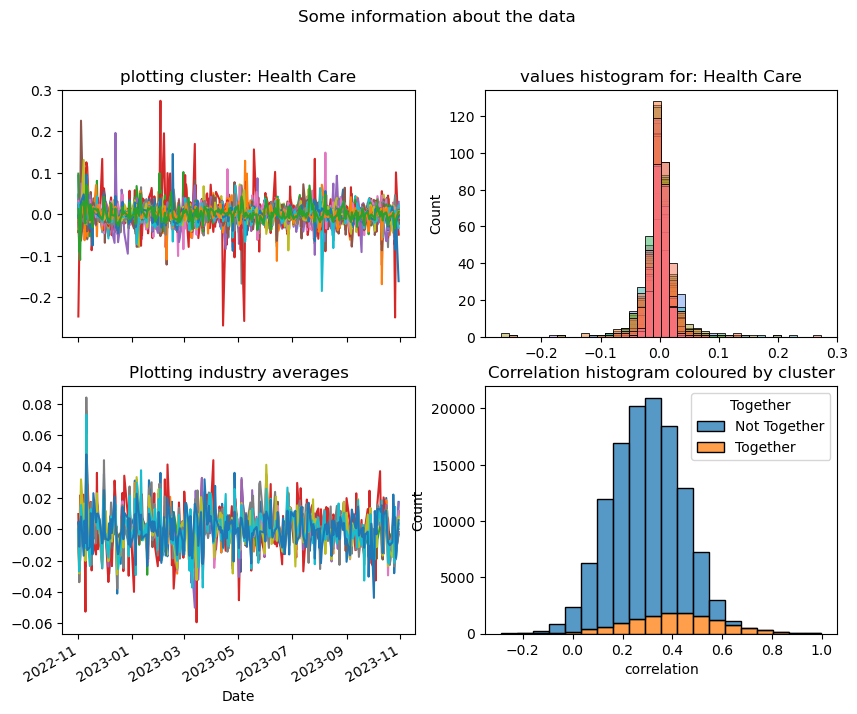

In [4]:
explore(ROR)

# Smoothing Returns
One possible transformation of the data is to smooth out the daily returns. This has the effect of making our analysis less sensitive to shocks, although it removes from the interpretability of the time series. Nevertheless, we examine what it does.

To smooth, we use two parameters: the window size, $k$, and the decay term, $0 < \alpha \le 1$. We then preform the following operation:
$$
\hat r_{n+k} = \frac{1}{\sum_{i=0}^{k-1} \alpha^i} \sum_{i=1}^{i = k} r_{n+k-i}\alpha^i
$$

The idea is to use ARMA-type moving averages to take a weighted sum of the returns, placing a large weight on the most recent one. Note that when $\alpha = 1$, this is just a rolling average.

<AxesSubplot:xlabel='Date'>

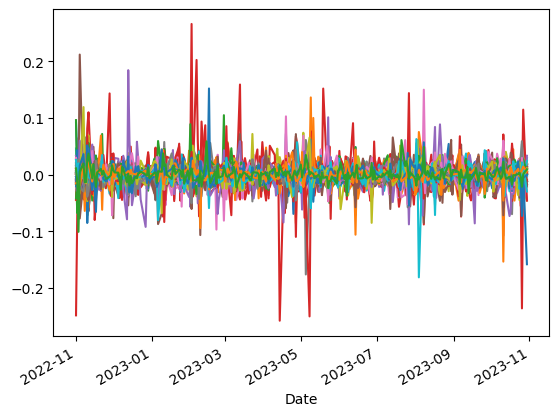

In [5]:
HC_industry_adj = ROR['Health Care'].sub(ROR['Health Care'].mean(axis = 1), axis = 0)
HC_industry_adj.plot(legend = False)

In [6]:
HC_smooth = HC_industry_adj.ewm(alpha = 0.5, adjust = True, axis = 0).mean()

#HC_smooth = HC_industry_adj.rolling(20).mean().dropna()

<AxesSubplot:xlabel='Date'>

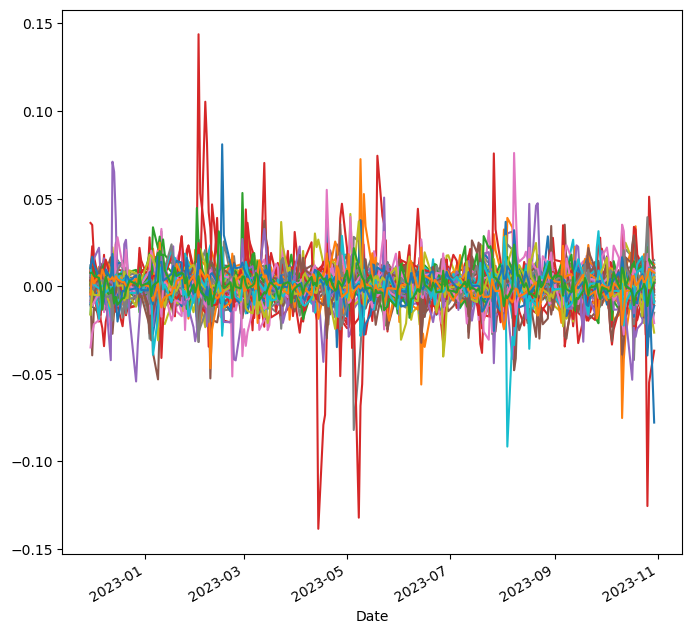

In [7]:
f, ax = plt.subplots(figsize = (8,8))

HC_smooth[20:].dropna().plot(legend = False, ax = ax)

Text(0.5, 1.0, 'values histogram for smoothed data')

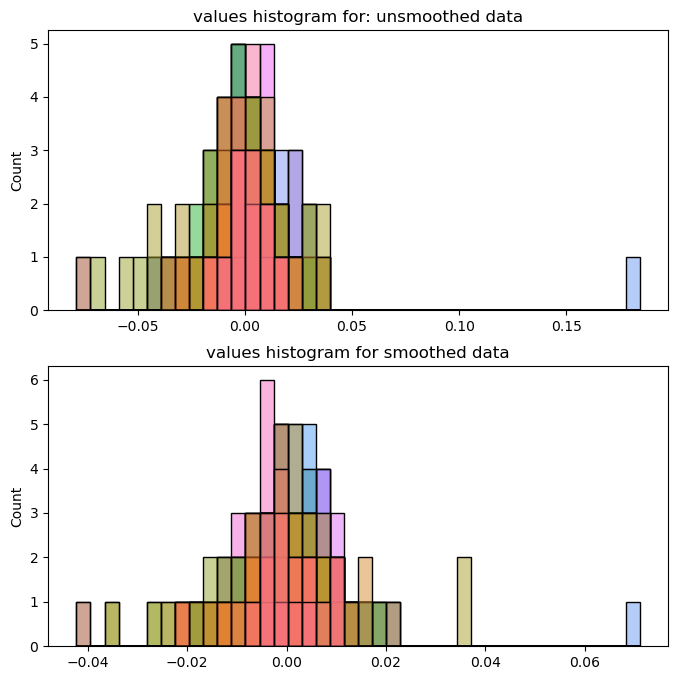

In [8]:
f, axarr = plt.subplots(2, 1, figsize = (8,8), sharex = False)

sns.histplot(HC_industry_adj[20:30], legend = False, ax = axarr[0], bins = 40)
axarr[0].set_title(f"values histogram for: unsmoothed data")

sns.histplot(HC_smooth[20:30], legend = False, ax = axarr[1], bins = 40)
axarr[1].set_title(f"values histogram for smoothed data")

In [9]:
from data_processing.preprocessing import market_adjust
from data_processing.preprocessing import industry_adjust

In [10]:
adjusted_ROR = industry_adjust(market_adjust(ROR))